<a href="https://colab.research.google.com/github/DiwakarBasnet/Cat_and_Dog_classifier/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Load data from kaggle into tf.dataset

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset --unzip

 98% 770M/788M [00:03<00:00, 242MB/s]
100% 788M/788M [00:03<00:00, 255MB/s]


In [8]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    shuffle = True,
    image_size = (256, 256),
    batch_size = 32
)

Found 25000 files belonging to 2 classes.


# Data visualization

In [10]:
class_names = dataset.class_names
class_names

['Cat', 'Dog']

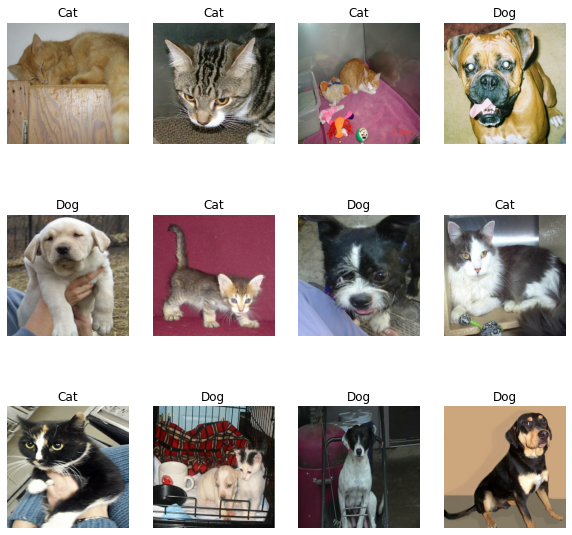

In [17]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

# Train Test Split in tensorflow

In [22]:
# 70% ==> training
# 30% ==> 15% ==> validation, 15% ==> test
# train_ds = dataset.take(547)    # train = arr[:547]
# test_ds = dataset.skip(547)     # test = arr[547:]
# val_ds = test_ds.take(117)      # val = test[:117]
# test_ds = test_ds.skip(117)     # test = test[117:]

def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, shuffle=True, shuffle_size=10000):
  
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds


In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [25]:
# .cache() -->
# reads image from disk and for next iteration when same image is needed, 
# it will keep that image in memory thus improves performance of pipeline
# .prefetch() -->
# if GPU is busy training, it will load next set of batch from disk to CPU and improves performance

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing

In [26]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [27]:
data_augmentaiton = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])